In [1]:
# Import all of the libraries that we will need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from matplotlib.ticker import MaxNLocator

# put the two csv files into two distinct dataframes
df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

# excluding the years that the league had less than 32 teams
excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
# dropping redundant values that could influence our results
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)

# this will allow us to merge the datasets
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']
to_scale = ['year', 'week', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

correlation_matrix = df_result_numerical.corr()

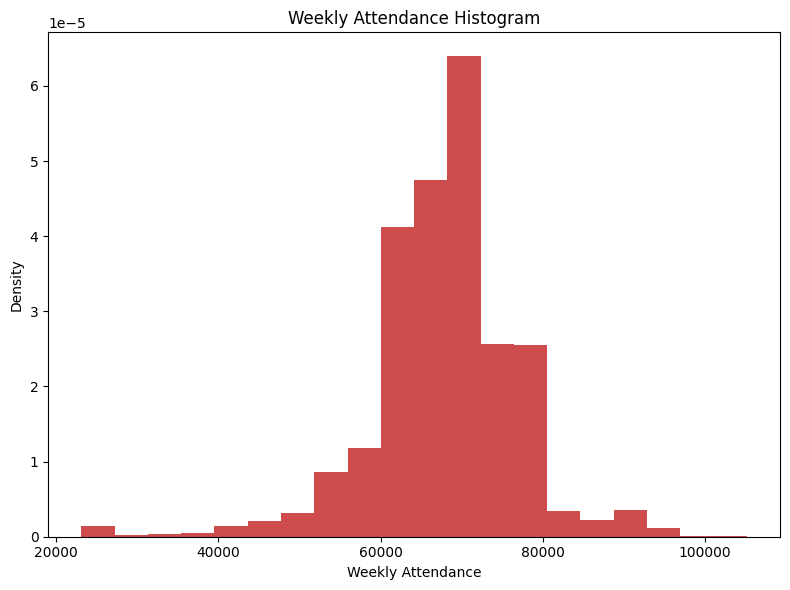

In [2]:
plt.figure(figsize=(8, 6))

# Plotting a histogram for the distribution of weekly attendance
plt.hist(df_result['weekly_attendance'], bins=20, density=True, alpha=0.7, color='#BB0000')

plt.xlabel('Weekly Attendance')
plt.ylabel('Density')
plt.title('Weekly Attendance Histogram')

plt.tight_layout()
plt.show()

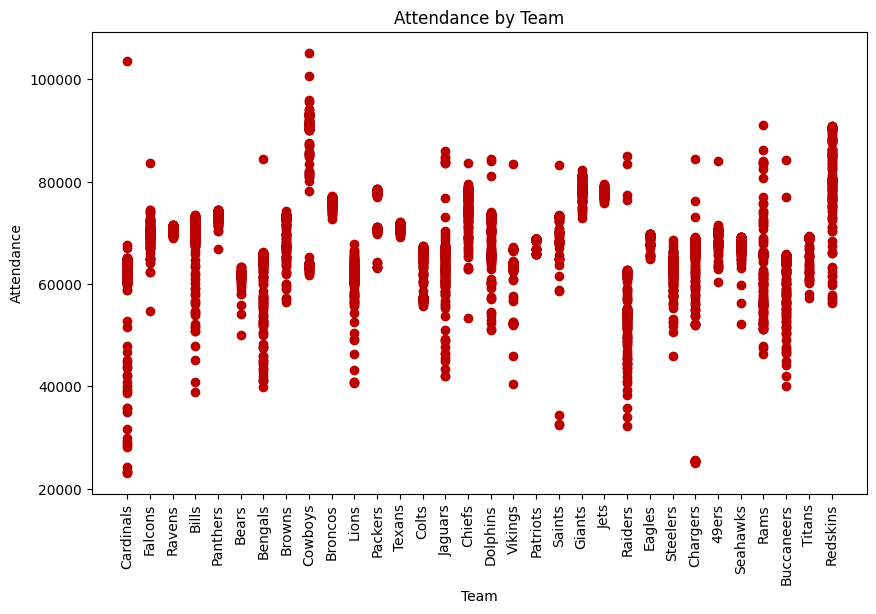

In [3]:
# Scatterplot for attendance on a team by team basis
plt.figure(figsize=(10,6))
plt.scatter(df_result['home_team_name'], df_result['weekly_attendance'], color='#BB0000')

plt.xlabel('Team')
plt.ylabel('Attendance')
plt.title('Attendance by Team')
plt.xticks(rotation=90)
plt.tight_layout

plt.show()

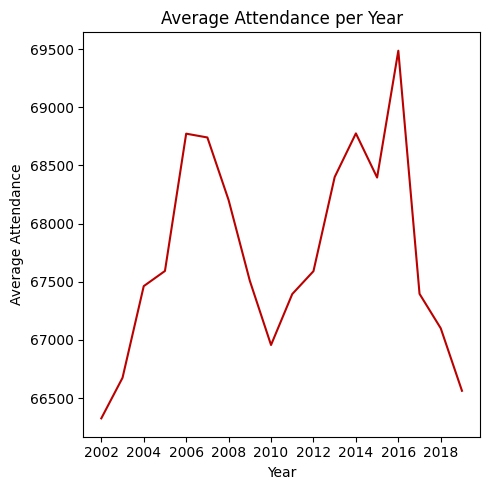

In [4]:
# League-wide average attendance from 2002 to 2019
avg_attendance_per_year = df_result.groupby('year')['weekly_attendance'].mean().reset_index()

plt.figure(figsize=(5, 5))
plt.plot(avg_attendance_per_year['year'], avg_attendance_per_year['weekly_attendance'], color='#BB0000')

plt.xlabel('Year')
plt.ylabel('Average Attendance')
plt.title('Average Attendance per Year')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

plt.show()

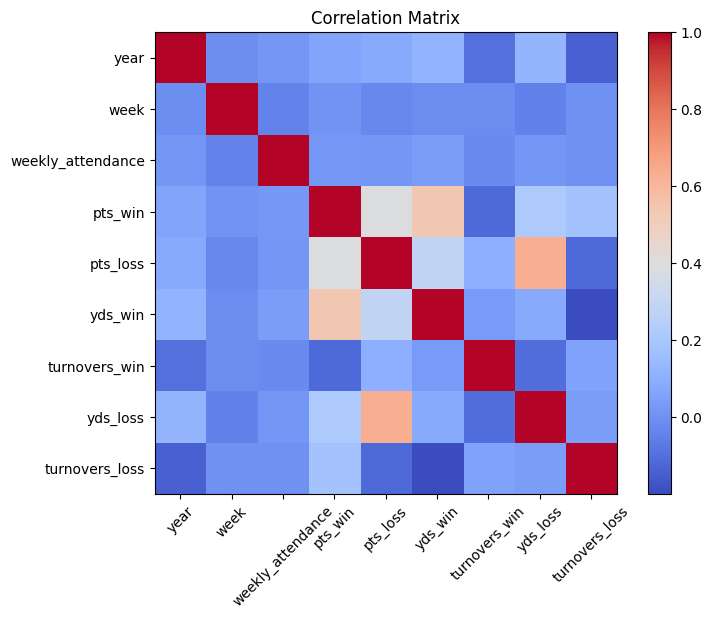

In [5]:
# This is showing ONLY the numerical values and how they correlate with one another
# The bluer, the less correlated. The redder, the more correlated...
# Note, the values down the diagonal are expected to be highly correlated, because it is comparing itself to itself
plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

In [6]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']

# 80/20 split for training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
scaled_dfs_train = []
scaled_dfs_test = []
for col in to_scale:
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train[[col]])
    scaled_test = scaler.transform(X_test[[col]])
    scaled_dfs_train.append(pd.DataFrame(scaled_train, columns=scaler.get_feature_names_out([col])))
    scaled_dfs_test.append(pd.DataFrame(scaled_test, columns=scaler.get_feature_names_out([col])))

X_train_scaled = pd.concat([X_train.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_train, axis=1)
X_test_scaled = pd.concat([X_test.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_test, axis=1)

In [8]:
#converting our categorical data into 1s and 0s
# for the purposes of One-Hot Encoding, considering we cannot run
# categorical data through our models
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train_scaled[[col]])
    encoded_test = encoder.transform(X_test_scaled[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)

In [9]:
def model_builder(hp):
    model = Sequential()
    hp_activation = hp.Choice('activation', values=['relu', 'selu', 'linear', 'mish'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=500, step=100)
    hp_dropout_1 = hp.Choice('dropout_layer_1', values=[1e-2, 1e-3, 1e-4])
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=500, step=100)
    hp_dropout_2 = hp.Choice('dropout_layer_2', values=[1e-2, 1e-3, 1e-4])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(Dense(units=hp_layer_1, activation=hp_activation))
    model.add(Dropout(hp_dropout_1))
    model.add(Dense(units=hp_layer_2, activation=hp_activation))
    model.add(Dropout(hp_dropout_2))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mse')
    return model

In [10]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='output',
                     project_name='attendance')

Reloading Tuner from output/attendance/tuner0.json


In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [12]:
tuner.search(X_train_encoded, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_encoded, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4004671744.0000 - val_loss: 127088576.0000
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 75729408.0000 - val_loss: 50443184.0000
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 33800208.0000 - val_loss: 46308400.0000
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 25252052.0000 - val_loss: 41420448.0000
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 28952200.0000 - val_loss: 39506464.0000
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 25242150.0000 - val_loss: 38286664.0000
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 23873092.0000 - val_loss: 38050340.0000
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 22835140.0000 - val_loss: 37873036.0000
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 20069638.0000 - val_loss: 36166528.0000
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 21068464.0000 - val_loss: 36144388.0000
Epoch 

In [15]:
y_pred = model.predict(X_test_encoded)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [16]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", np.sqrt(mse))
print("R2 Score: ", r2_score)

Mean Squared Error: 28145118.855408896
Mean Absolute Error:  3174.170775572804
Root Mean Squared Error:  5305.197343681844
R2 Score:  0.6546944002034765


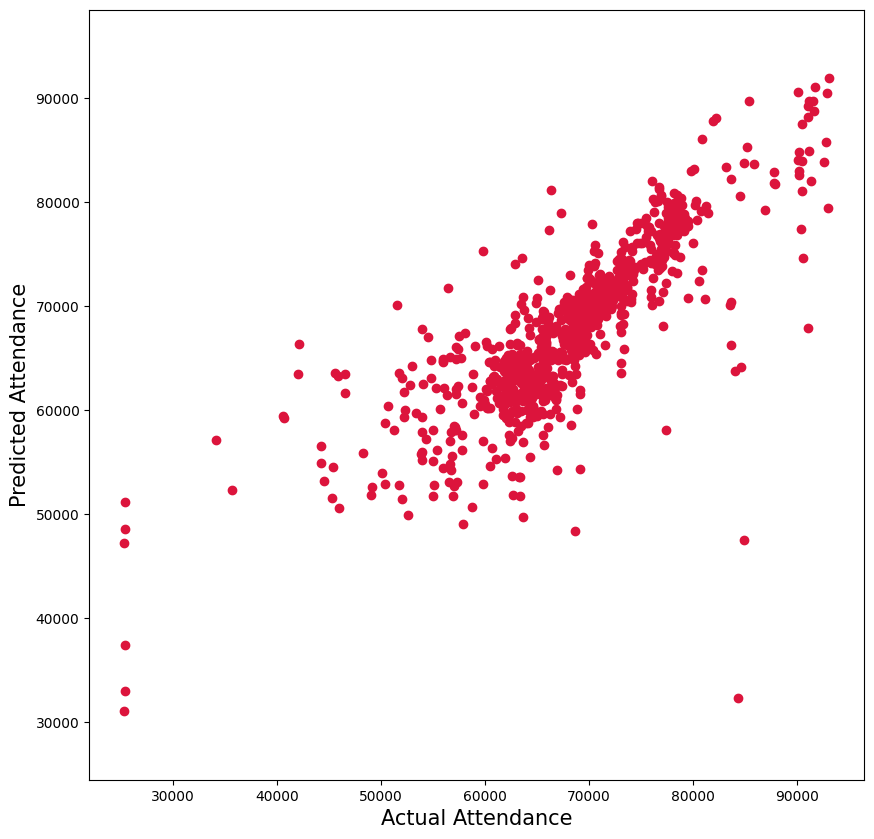

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.axis('equal')
plt.show()

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 401)               │     45,313 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 401)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 101)               │     40,602 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 101)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │        102 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 258,053 (1008.02 KB)

 Trainable params: 86,017 (336.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 172,036 (672.02 KB)